# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1cfrNG9f8JpHIvT45QBMp3Fi3tBMpN-PM/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170M/170M [00:06<00:00, 28.1MB/s]


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

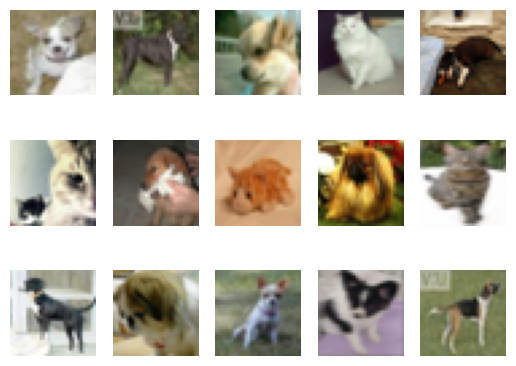

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
num_train_examples = len(train_loader)

num_val_examples = len(val_loader)

num_test_examples = len(test_loader)

print(f"Number of training examples (cat and dog combined): {num_train_examples}")
print(f"Number of validation examples (cat and dog combined): {num_val_examples}")
print(f"Number of test examples (cat and dog combined): {num_test_examples}")

Number of training examples (cat and dog combined): 8000
Number of validation examples (cat and dog combined): 2000
Number of test examples (cat and dog combined): 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

**We need a validation set when training a model to evaluate how well it generalizes to unseen data. If we judge the model’s performance using only the training set loss or error, we risk overestimating its effectiveness, as the model may simply memorize the training data rather than learn meaningful patterns — a problem known as overfitting. The validation set provides an unbiased assessment of the model's performance and is essential for tuning hyperparameters and selecting the best version of the model. Without it, we have no reliable way to detect whether the model will perform well on new, real-world data.**

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [ ]:
def count_parameters(model):
    total_params = sum(np.prod(p.shape) for p in model.parameters())
    return total_params
small_net_params = count_parameters(small_net)
large_net_params = count_parameters(large_net)
print(f"Number of parameters in small_net: {small_net_params}")
print(f"Number of parameters in large_net: {large_net_params}")

Number of parameters in small_net: 386
Number of parameters in large_net: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

**As defined in the header of the train_net function, the default values of batch_size is 64, learning_rate is 0.01, and num_epochs is 30.**

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

**The code is designed to save the model’s parameters after each completed epoch, resulting in five separate parameter sets across five epochs. Additionally, it generates files that log key performance metrics—training error, training loss, validation error, and validation loss—across all five trials.  Specifically, there are five saved parameter files for the small_net model. The file named small_net_bs64_lr0.01_epoch4_train_err.csv records the training error at the end of each epoch. Likewise, small_net_bs64_lr0.01_epoch4_train_loss.csv tracks the training loss after every epoch. The file small_net_bs64_lr0.01_epoch4_val_err.csv logs the validation error across epochs, and small_net_bs64_lr0.01_epoch4_val_loss.csv stores the validation loss values. Each of these files holds five entries—one for each epoch completed during training.**

In [ ]:
train_net(small_net, batch_size = 64, learning_rate = 0.01, num_epochs = 5)

Epoch 1: Train err: 0.335, Train loss: 0.6151189250946045 |Validation err: 0.338, Validation loss: 0.6238158978521824
Epoch 2: Train err: 0.3285, Train loss: 0.6063321375846863 |Validation err: 0.343, Validation loss: 0.6299348585307598
Epoch 3: Train err: 0.322625, Train loss: 0.6003852133750915 |Validation err: 0.3335, Validation loss: 0.6081425491720438
Epoch 4: Train err: 0.319875, Train loss: 0.5941172547340393 |Validation err: 0.343, Validation loss: 0.6209295857697725
Epoch 5: Train err: 0.31375, Train loss: 0.5912032821178437 |Validation err: 0.334, Validation loss: 0.6145435161888599
Finished Training
Total time elapsed: 17.49 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)
train_net(large_net)

Epoch 1: Train err: 0.30975, Train loss: 0.5855858118534089 |Validation err: 0.3265, Validation loss: 0.6117713786661625
Epoch 2: Train err: 0.308, Train loss: 0.5839925878047943 |Validation err: 0.336, Validation loss: 0.6294938363134861
Epoch 3: Train err: 0.30675, Train loss: 0.5811943500041962 |Validation err: 0.3215, Validation loss: 0.6035341676324606
Epoch 4: Train err: 0.302625, Train loss: 0.5780185942649841 |Validation err: 0.3355, Validation loss: 0.6069435514509678
Epoch 5: Train err: 0.302875, Train loss: 0.5777840669155121 |Validation err: 0.327, Validation loss: 0.607693387195468
Epoch 6: Train err: 0.298875, Train loss: 0.5742512893676758 |Validation err: 0.3185, Validation loss: 0.6094243451952934
Epoch 7: Train err: 0.299875, Train loss: 0.5738461632728576 |Validation err: 0.314, Validation loss: 0.6010102052241564
Epoch 8: Train err: 0.296875, Train loss: 0.5719555380344391 |Validation err: 0.318, Validation loss: 0.6023132028058171
Epoch 9: Train err: 0.293875, Trai

**The small network took 109.40 seconds to train, while the large network took 122.09 seconds to train.**

**The large network has more layers and parameters than the small one, making both the forward pass and parameter updates more computationally intensive. As a result, training takes longer due to the increased runtime required to update its larger set of parameters after each batch.**

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Small Model Training Curves


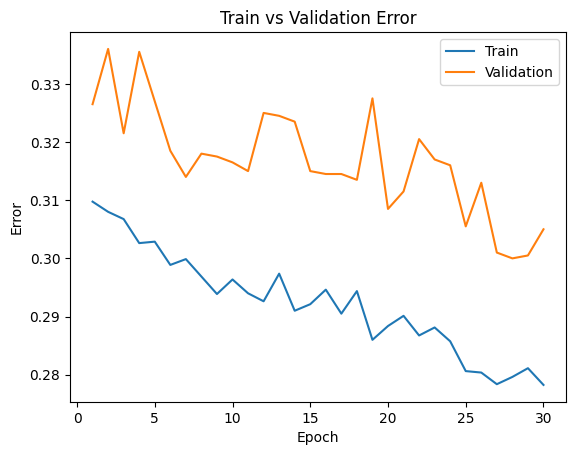

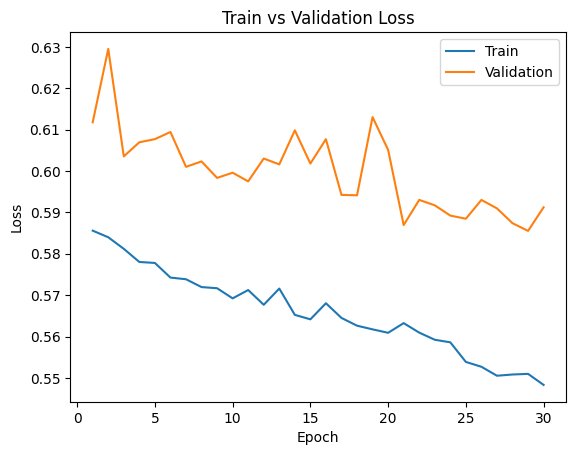

Large Model Training Curves


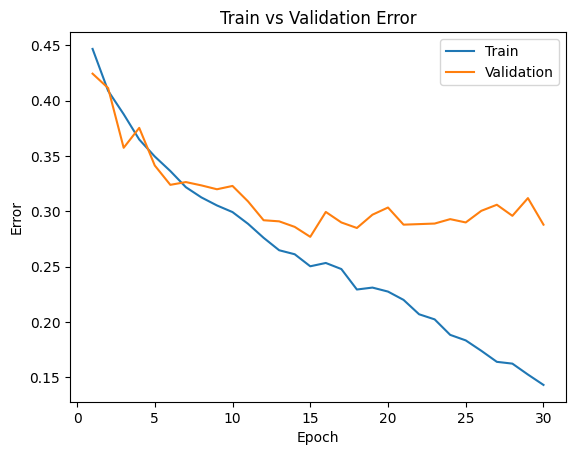

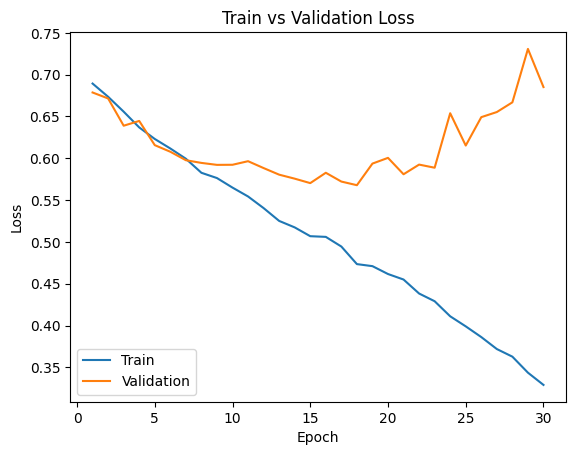

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
small_model = get_model_name("small", batch_size = 64, learning_rate = 0.01, epoch = 29)
print("Small Model Training Curves")
plot_training_curve(small_model)
large_model = get_model_name("large", batch_size = 64, learning_rate = 0.01, epoch = 29)
print("Large Model Training Curves")
plot_training_curve(large_model)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**The training curves reveal key differences between the performance of small_net and large_net. For small_net, the training loss consistently decreases, but the validation loss fluctuates and remains higher, indicating overfitting—the model is learning the training data well but failing to generalize to unseen data. In contrast, large_net shows a steady decline in both training and validation error in the first 15 epochs; however, the validation error plateaus after 15 epochs while the validation loss increases, which indicate the start of overfitting. This suggests better generalization and less overfitting in the first 15 epochs. There is no evidence of underfitting in either model, as both begin with high error and improve over time. Overall, the larger network demonstrates more stable and effective learning behavior.**

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Epoch 1: Train err: 0.47625, Train loss: 0.692836000919342 |Validation err: 0.467, Validation loss: 0.6924686599522829
Epoch 2: Train err: 0.448625, Train loss: 0.6922589721679687 |Validation err: 0.4305, Validation loss: 0.6916493345052004
Epoch 3: Train err: 0.43575, Train loss: 0.6916067314147949 |Validation err: 0.4285, Validation loss: 0.690854461863637
Epoch 4: Train err: 0.43, Train loss: 0.6908613452911377 |Validation err: 0.424, Validation loss: 0.6896595247089863
Epoch 5: Train err: 0.434125, Train loss: 0.6899194960594177 |Validation err: 0.4195, Validation loss: 0.6886935196816921
Epoch 6: Train err: 0.43575, Train loss: 0.6887412714958191 |Validation err: 0.4195, Validation loss: 0.6867827028036118
Epoch 7: Train err: 0.436875, Train loss: 0.6873777761459351 |Validation err: 0.4185, Validation loss: 0.6851987466216087
Epoch 8: Train err: 0.437375, Train loss: 0.6859265780448913 |Validation err: 0.4115, Validation loss: 0.6831984501332045
Epoch 9: Train err: 0.4245, Train l

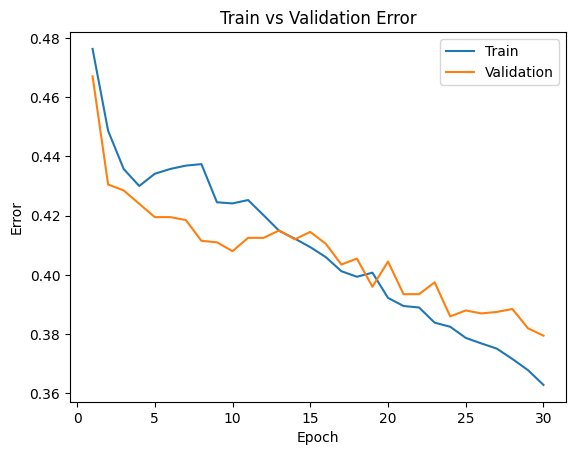

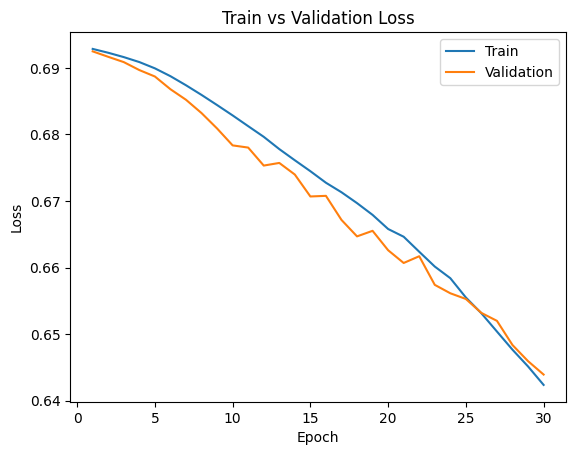

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001)
large_net_path = get_model_name("large", batch_size = 64, learning_rate = 0.001, epoch = 29)
plot_training_curve(large_net_path)

**The large_net took 122.64 seconds to train, which is approximately the same time to train the large_net with a learning_rate of 0.01.  A lower learning_rate allowed the train and validation error and loss to decrease simultaneously, which indicates that there is less overfitting.  A lower learning_rate suggests that the parameters of the models are being updated at smaller increments, which means it's converging slower as error and loss are decreasing slower over the epochs.**

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Epoch 1: Train err: 0.4275, Train loss: 0.6742977576255799 |Validation err: 0.3765, Validation loss: 0.6370317284017801
Epoch 2: Train err: 0.368375, Train loss: 0.6400856475830078 |Validation err: 0.355, Validation loss: 0.6248273365199566
Epoch 3: Train err: 0.357, Train loss: 0.6258103733062744 |Validation err: 0.3435, Validation loss: 0.6111582862213254
Epoch 4: Train err: 0.348625, Train loss: 0.6193035726547241 |Validation err: 0.3445, Validation loss: 0.6090600434690714
Epoch 5: Train err: 0.330875, Train loss: 0.6069964556694031 |Validation err: 0.3205, Validation loss: 0.596891101449728
Epoch 6: Train err: 0.31825, Train loss: 0.5847644197940827 |Validation err: 0.3175, Validation loss: 0.6014995649456978
Epoch 7: Train err: 0.310125, Train loss: 0.5844504687786102 |Validation err: 0.32, Validation loss: 0.5886365985497832
Epoch 8: Train err: 0.298875, Train loss: 0.5663281762599945 |Validation err: 0.332, Validation loss: 0.6052035521715879
Epoch 9: Train err: 0.30175, Train 

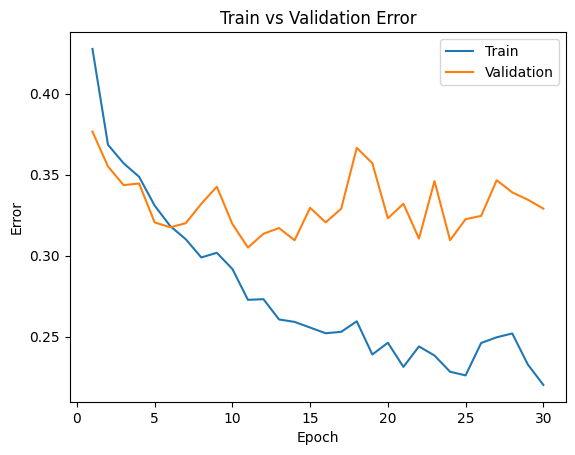

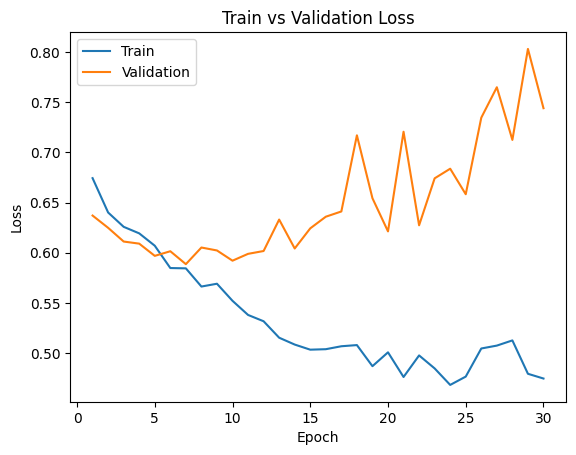

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)
large_net_path = get_model_name("large", batch_size = 64, learning_rate = 0.1, epoch = 29)
plot_training_curve(large_net_path)

**The large_net took 126.05 seconds to train, which is approximately the same as the same model with learning_rates of 0.01 and 0.001.  A larger learning rate suggests that the parameters are being updated at bigger increments, which allowed the model to converge earlier.  However, overfitting occured relatively early at 5 epochs, where the validation loss begin to increase while the train loss continued to decrease.**

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Epoch 1: Train err: 0.48175, Train loss: 0.6929379515349865 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908450163900852 |Validation err: 0.424, Validation loss: 0.6897871196269989
Epoch 5: Train err: 0.434, Train loss: 0.6896936148405075 |Validation err: 0.424, Validation loss: 0.6881358474493027
Epoch 6: Train err: 0.43825, Train loss: 0.6883535124361515 |Validation err: 0.4285, Validation loss: 0.6860134303569794
Epoch 7: Train err: 0.43925, Train loss: 0.6866881027817726 |Validation err: 0.426, Validation loss: 0.6836977005004883
Epoch 8: Train err: 0.43525, Train loss: 0.6849788874387741 |Validation err: 0.412, Validation loss: 0.681468278169632
Epoch 9: Train err: 0.42375, Train loss: 

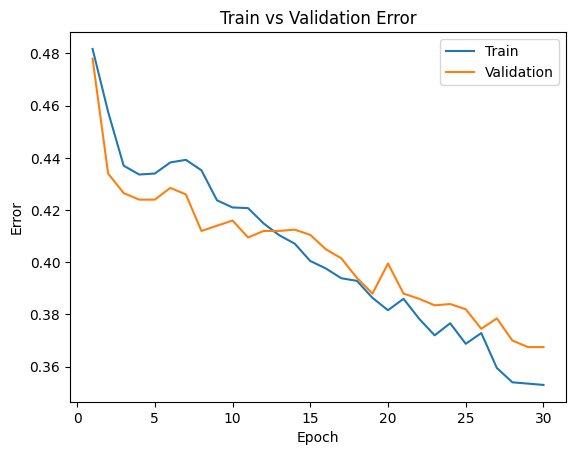

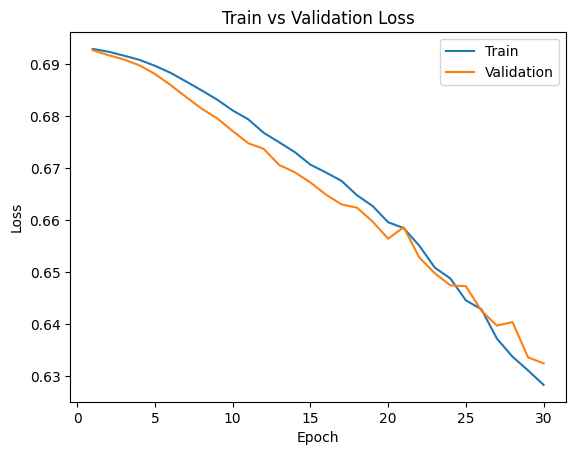

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.01, batch_size = 512)
large_net_path = get_model_name("large", batch_size = 512, learning_rate = 0.01, epoch = 29)
plot_training_curve(large_net_path)

**The model took 112.84 seconds to train, which is apporximately 12 seconds faster than its 64 batch counterpart.  Increasing the batch size prevented overfitting as the training and validation error and loss both decreased over the epochs.  However, slight underfitting can be observed in the first 10 epochs as the training error and loss are both higher than the validations's.**

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Epoch 1: Train err: 0.432625, Train loss: 0.6775506120920182 |Validation err: 0.378, Validation loss: 0.6512572045326233
Epoch 2: Train err: 0.365625, Train loss: 0.6391648109555245 |Validation err: 0.3445, Validation loss: 0.6164793245792389
Epoch 3: Train err: 0.342, Train loss: 0.6151252817511559 |Validation err: 0.336, Validation loss: 0.6379956350326538
Epoch 4: Train err: 0.314125, Train loss: 0.5860003986954689 |Validation err: 0.3415, Validation loss: 0.6001057889461517
Epoch 5: Train err: 0.301, Train loss: 0.5655734999775887 |Validation err: 0.2985, Validation loss: 0.577371990442276
Epoch 6: Train err: 0.285125, Train loss: 0.5443512217998505 |Validation err: 0.294, Validation loss: 0.5772789006233215
Epoch 7: Train err: 0.27, Train loss: 0.5273003922700882 |Validation err: 0.284, Validation loss: 0.5634327342510224
Epoch 8: Train err: 0.25625, Train loss: 0.5123887906968594 |Validation err: 0.2965, Validation loss: 0.5823068192005157
Epoch 9: Train err: 0.250875, Train loss

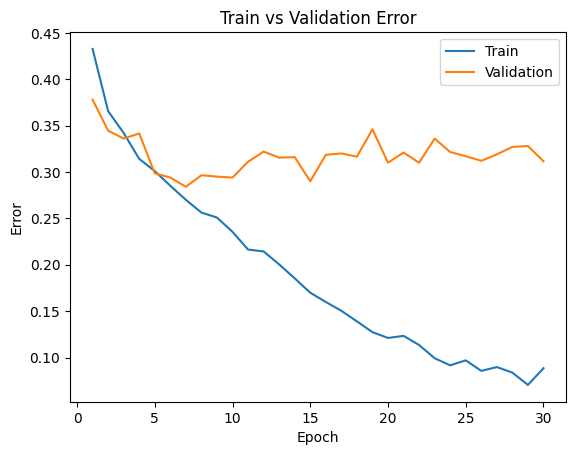

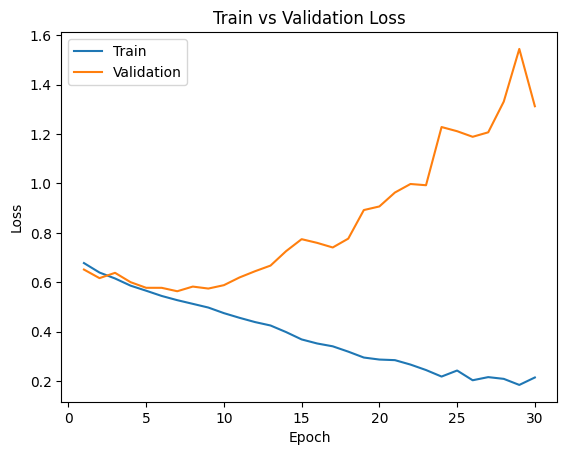

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.01, batch_size = 16)
large_net_path = get_model_name("large", batch_size = 16, learning_rate = 0.01, epoch = 29)
plot_training_curve(large_net_path)

**The model took 176.51 seconds to train, which is significantly longer than the previous models.  Decreasing the batch size was able to decrease training and validation error and loss for the first five epochs.  However, the model started to overfit significantly after the first five epochs, as training error and loss decreased steadily while validation error and loss began to increase.**

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**I would select the large_network because it shows consistent improvement in validation accuracy over time, indicating better generalization compared to the small_network. For the batch_size, I would choose 512, as it results in the least amount of overfitting. Regarding the learning_rate, I would opt for 0.001, since it also demonstrates minimal overfitting. However, a smaller learning rate means the model parameters are updated more gradually, which could require more training epochs to achieve convergence. For now, I will keep the number of epochs at 30.**

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362003087997
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280422627926 |Validation err: 0.493, Validation loss: 0.692953959107399
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.6927744150161743 |Validation err: 0.4835, Validation loss: 0.692750483751297
Epoch 6: Train err: 0.469, Train loss: 0.6926896199584007 |Validation err: 0.472, Validation loss: 0.6926551908254623
Epoch 7: Train err: 0.46325, Train loss: 0.6926203556358814 |Validation err: 0.47, Validation loss: 0.6925524771213531
Epoch 8: Train err: 0.46225, Train loss: 0.6925435625016689 |Validation err: 0.463, Validation loss: 0.6924485266208649
Epoch 9: Train err: 0.459625, Train loss: 

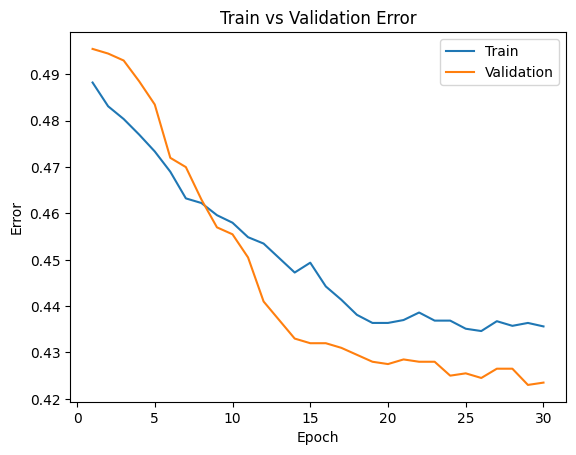

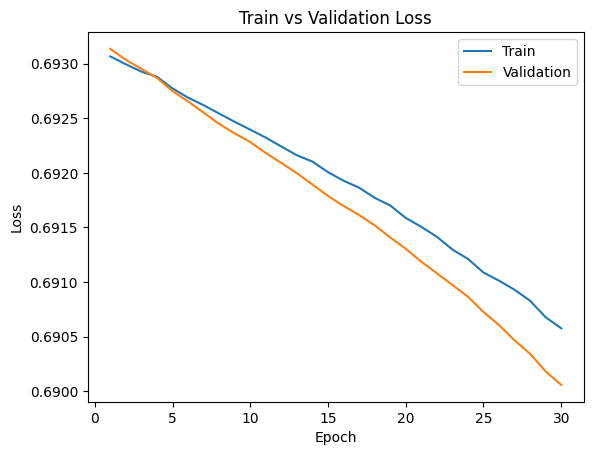

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001, batch_size = 512)
large_net_path = get_model_name("large", batch_size = 512, learning_rate = 0.001, epoch = 29)
plot_training_curve(large_net_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

**The results from part (a) and (b) shows that the training and validation error and loss both decreased until around the 20th epoch, where the error plateaued.  In addition, the validation error and loss are lower than the training's after the 5th epoch, which suggests that underfitting is occuring.  As a result, I believe that the learning rate should be increased to 0.005 so the parameters are being updated at bigger increments, allowing the model to converge.  In addition, the batch size should also be lowered to decrease underfitting.  Therefore, the batch size is changed to 128.**

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Epoch 1: Train err: 0.466625, Train loss: 0.6925613303033132 |Validation err: 0.4305, Validation loss: 0.6916250288486481
Epoch 2: Train err: 0.45025, Train loss: 0.691034596117716 |Validation err: 0.4295, Validation loss: 0.6889704093337059
Epoch 3: Train err: 0.430375, Train loss: 0.6885878623477997 |Validation err: 0.4165, Validation loss: 0.6849985718727112
Epoch 4: Train err: 0.430625, Train loss: 0.6850001168629479 |Validation err: 0.4125, Validation loss: 0.6797108538448811
Epoch 5: Train err: 0.420875, Train loss: 0.6813877849351793 |Validation err: 0.411, Validation loss: 0.6762746684253216
Epoch 6: Train err: 0.415875, Train loss: 0.6773035592503018 |Validation err: 0.4125, Validation loss: 0.6729709170758724
Epoch 7: Train err: 0.405, Train loss: 0.6732282080347576 |Validation err: 0.4055, Validation loss: 0.6696020103991032
Epoch 8: Train err: 0.4005, Train loss: 0.669418770169455 |Validation err: 0.402, Validation loss: 0.6651135161519051
Epoch 9: Train err: 0.39075, Train

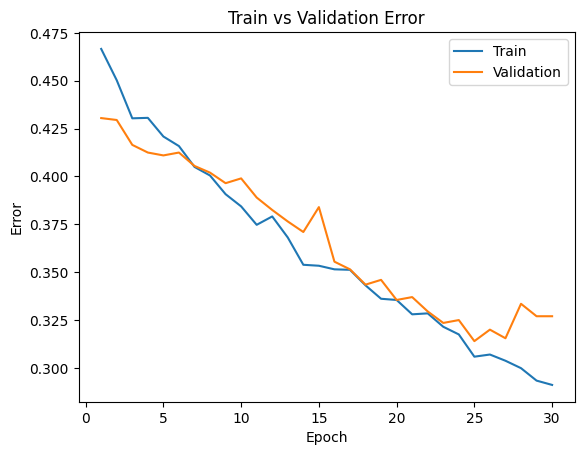

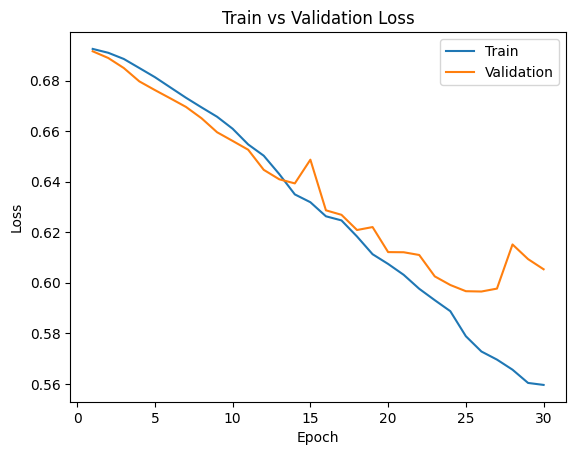

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.005, batch_size = 128)
large_net_path = get_model_name("large", batch_size = 128, learning_rate = 0.005, epoch = 29)
plot_training_curve(large_net_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.005, epoch=25)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

**Following the explanation from part 4 (c), the chosen model exhibited the best validation error and loss from the different training iterations.  By employing the early stopping strategy, the model at the 25th epoch was chosen, as it had the best validation loss of 0.597 and the best validation error of 0.314, while the later epochs demonstrated higher loss and error due to overfitting.**

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print(f"Test error: {test_err}")
print(f"Test loss: {test_loss}")

Test error: 0.3225
Test loss: 0.5913828257471323


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

**The test classification error is 0.3225, slightly higher than the validation error of 0.314. This is expected, as the model’s hyperparameters were tuned to optimize performance on the validation set, which can lead to slightly better accuracy on that set compared to the unseen test data.**

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**We only use the test dataset at the very end to get an unbiased estimate of how well our model will perform on completely unseen data. If we use the test data during training or hyperparameter tuning, we risk overfitting to it, which would make the final evaluation unreliable.**

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Epoch 1: Train err: 0.404625, Train loss: 0.6614987754821777 |Validation err: 0.3755, Validation loss: 0.6457115057855844
Epoch 2: Train err: 0.364, Train loss: 0.6333475842475891 |Validation err: 0.3925, Validation loss: 0.6563094612210989
Epoch 3: Train err: 0.342375, Train loss: 0.6185531120300293 |Validation err: 0.3735, Validation loss: 0.6442472171038389
Epoch 4: Train err: 0.332125, Train loss: 0.6079756269454956 |Validation err: 0.388, Validation loss: 0.657328249886632
Epoch 5: Train err: 0.311, Train loss: 0.5888664021492004 |Validation err: 0.3775, Validation loss: 0.6452679298818111
Epoch 6: Train err: 0.29125, Train loss: 0.5660493175983429 |Validation err: 0.4055, Validation loss: 0.7052247021347284
Epoch 7: Train err: 0.284375, Train loss: 0.5541181931495667 |Validation err: 0.3775, Validation loss: 0.6580966040492058
Epoch 8: Train err: 0.260875, Train loss: 0.5274498057365418 |Validation err: 0.3635, Validation loss: 0.6711820187047124
Epoch 9: Train err: 0.2585, Train

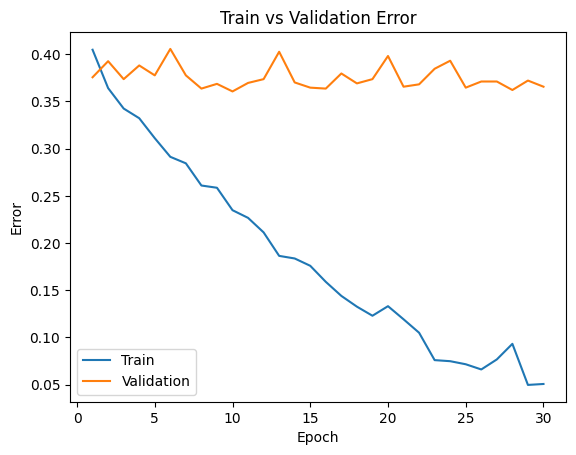

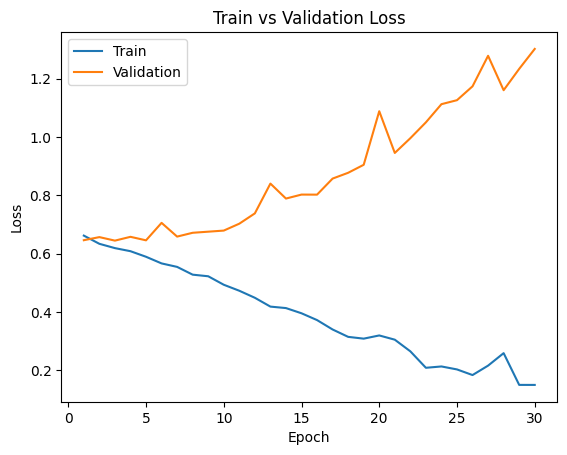

Epoch 1: Train err: 0.44275, Train loss: 0.6823749244213104 |Validation err: 0.4125, Validation loss: 0.669428750872612
Epoch 2: Train err: 0.398625, Train loss: 0.6628583781421185 |Validation err: 0.3985, Validation loss: 0.6585346460342407
Epoch 3: Train err: 0.384125, Train loss: 0.6520870849490166 |Validation err: 0.393, Validation loss: 0.6550165414810181
Epoch 4: Train err: 0.375875, Train loss: 0.6452020816504955 |Validation err: 0.38, Validation loss: 0.6512135714292526
Epoch 5: Train err: 0.371, Train loss: 0.638361107558012 |Validation err: 0.38, Validation loss: 0.6486649364233017
Epoch 6: Train err: 0.36175, Train loss: 0.6337083354592323 |Validation err: 0.387, Validation loss: 0.6486920863389969
Epoch 7: Train err: 0.354625, Train loss: 0.6285756006836891 |Validation err: 0.3825, Validation loss: 0.6467981934547424
Epoch 8: Train err: 0.345375, Train loss: 0.6224926635622978 |Validation err: 0.376, Validation loss: 0.6452675014734268
Epoch 9: Train err: 0.34075, Train los

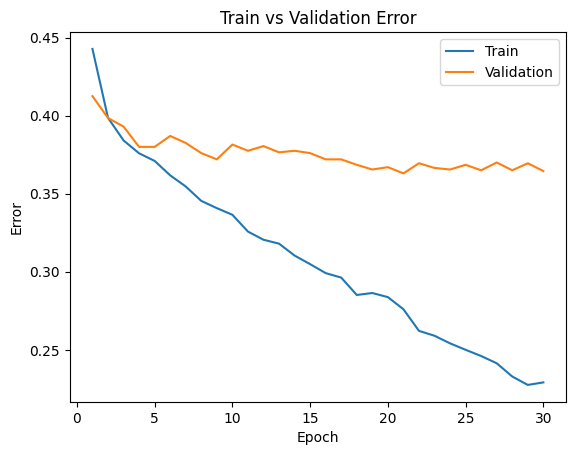

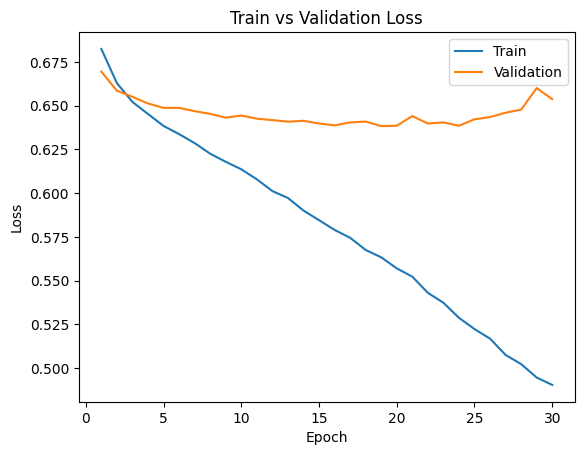

Epoch 1: Train err: 0.40625, Train loss: 0.6672525942921639 |Validation err: 0.394, Validation loss: 0.6522243046760559
Epoch 2: Train err: 0.387625, Train loss: 0.6519210290908813 |Validation err: 0.389, Validation loss: 0.6604517924785615
Epoch 3: Train err: 0.365, Train loss: 0.6404699067473412 |Validation err: 0.3935, Validation loss: 0.6632598826885223
Epoch 4: Train err: 0.350375, Train loss: 0.6265215368866921 |Validation err: 0.4, Validation loss: 0.6626028380393982
Epoch 5: Train err: 0.336125, Train loss: 0.619730961740017 |Validation err: 0.37, Validation loss: 0.6739283831119537
Epoch 6: Train err: 0.319875, Train loss: 0.6016252175569534 |Validation err: 0.404, Validation loss: 0.6842417359352112
Epoch 7: Train err: 0.30475, Train loss: 0.5936459739804267 |Validation err: 0.3645, Validation loss: 0.6803097305297852
Epoch 8: Train err: 0.284375, Train loss: 0.5715757707357406 |Validation err: 0.365, Validation loss: 0.677047532081604
Epoch 9: Train err: 0.271, Train loss: 0

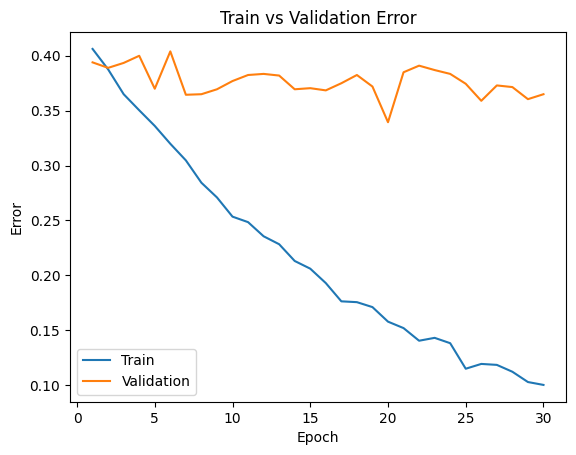

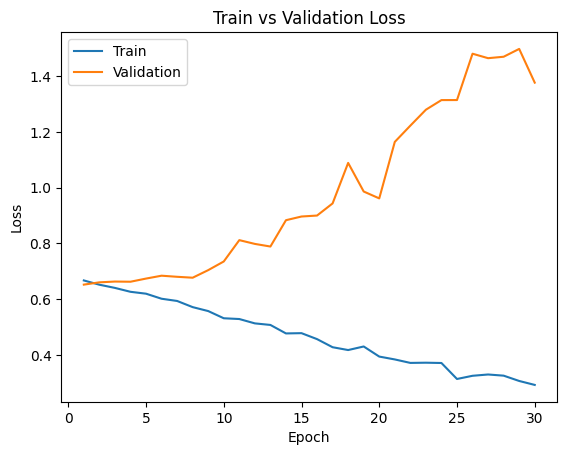

Epoch 1: Train err: 0.4295, Train loss: 0.678065315246582 |Validation err: 0.4055, Validation loss: 0.6661413311958313
Epoch 2: Train err: 0.393875, Train loss: 0.6607295970916748 |Validation err: 0.404, Validation loss: 0.6581725981086493
Epoch 3: Train err: 0.38525, Train loss: 0.6523881220817566 |Validation err: 0.3935, Validation loss: 0.6542905103415251
Epoch 4: Train err: 0.376, Train loss: 0.646045536994934 |Validation err: 0.3935, Validation loss: 0.6523004081100225
Epoch 5: Train err: 0.3665, Train loss: 0.6410966854095459 |Validation err: 0.3795, Validation loss: 0.6493838522583246
Epoch 6: Train err: 0.365, Train loss: 0.6355259761810302 |Validation err: 0.3795, Validation loss: 0.647342199459672
Epoch 7: Train err: 0.35925, Train loss: 0.6311114234924317 |Validation err: 0.375, Validation loss: 0.6466870326548815
Epoch 8: Train err: 0.35, Train loss: 0.6267297382354736 |Validation err: 0.3745, Validation loss: 0.6446432489901781
Epoch 9: Train err: 0.347, Train loss: 0.6228

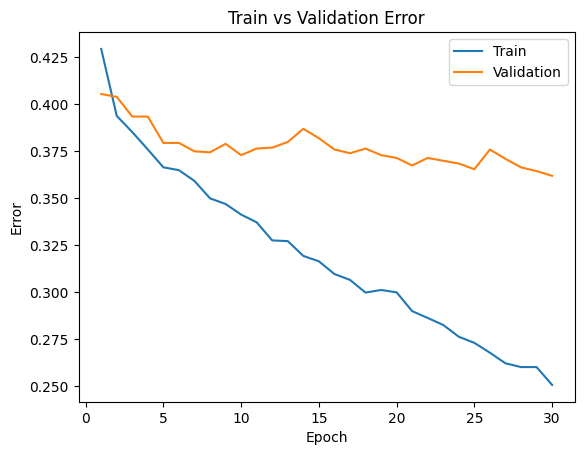

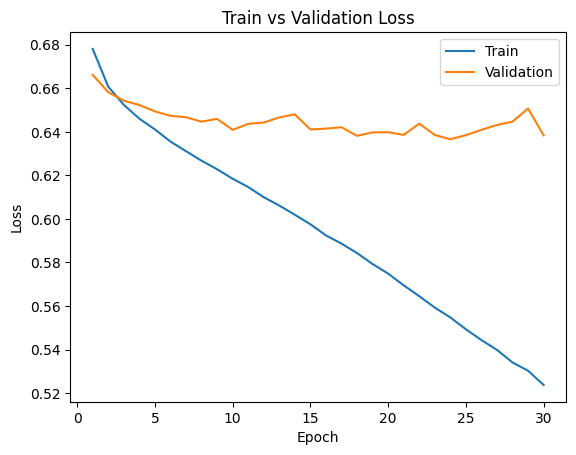

Epoch 1: Train err: 0.437, Train loss: 0.7138984980583191 |Validation err: 0.4665, Validation loss: 0.8214013110846281
Epoch 2: Train err: 0.43425, Train loss: 0.8227891340255737 |Validation err: 0.4395, Validation loss: 0.7124098055064678
Epoch 3: Train err: 0.44575, Train loss: 0.8591925506591797 |Validation err: 0.4445, Validation loss: 0.8397880271077156
Epoch 4: Train err: 0.437125, Train loss: 0.8617679409980774 |Validation err: 0.453, Validation loss: 0.7978323325514793
Epoch 5: Train err: 0.423625, Train loss: 0.931370780467987 |Validation err: 0.454, Validation loss: 1.0371004063636065
Epoch 6: Train err: 0.43375, Train loss: 0.9369075765609741 |Validation err: 0.475, Validation loss: 1.0278988182544708
Epoch 7: Train err: 0.432375, Train loss: 0.9961738200187683 |Validation err: 0.4345, Validation loss: 0.8899163380265236
Epoch 8: Train err: 0.4345, Train loss: 1.0763423581123353 |Validation err: 0.4615, Validation loss: 1.0931234899908304
Epoch 9: Train err: 0.443875, Train 

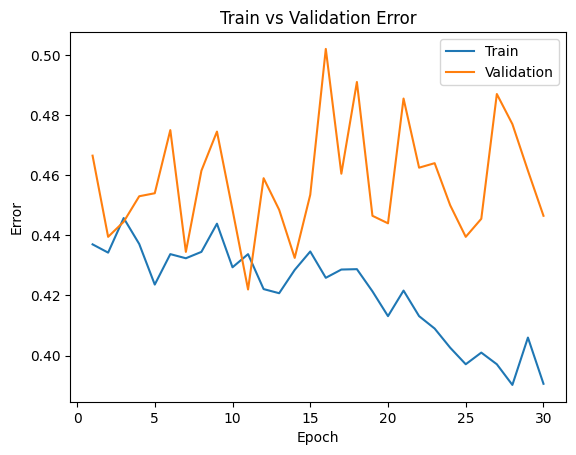

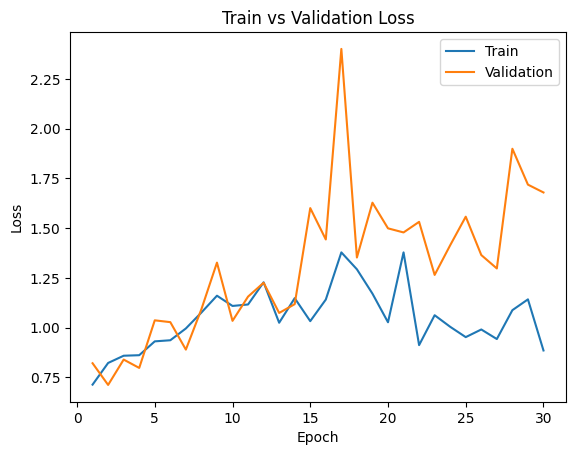

Epoch 1: Train err: 0.485, Train loss: 0.6928514614701271 |Validation err: 0.4495, Validation loss: 0.6891743689775467
Epoch 2: Train err: 0.442125, Train loss: 0.6861006878316402 |Validation err: 0.4225, Validation loss: 0.6826349496841431
Epoch 3: Train err: 0.42175, Train loss: 0.6801529601216316 |Validation err: 0.4185, Validation loss: 0.6781371980905533
Epoch 4: Train err: 0.414625, Train loss: 0.6756206005811691 |Validation err: 0.415, Validation loss: 0.6747893691062927
Epoch 5: Train err: 0.4085, Train loss: 0.6718532927334309 |Validation err: 0.4075, Validation loss: 0.6720966100692749
Epoch 6: Train err: 0.405, Train loss: 0.669320784509182 |Validation err: 0.4055, Validation loss: 0.6698531210422516
Epoch 7: Train err: 0.401875, Train loss: 0.6670425832271576 |Validation err: 0.4025, Validation loss: 0.6681910157203674
Epoch 8: Train err: 0.39925, Train loss: 0.6651003062725067 |Validation err: 0.401, Validation loss: 0.6665802896022797
Epoch 9: Train err: 0.39475, Train lo

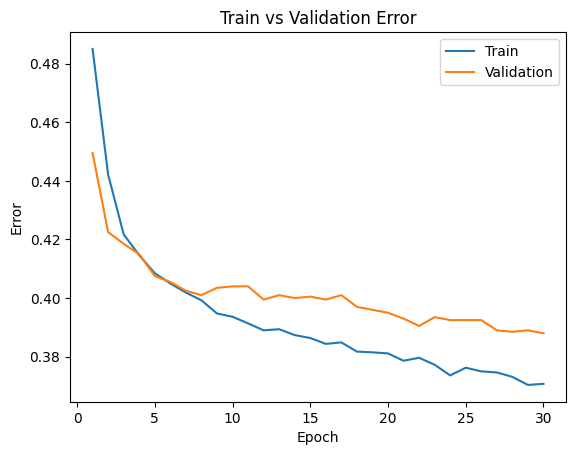

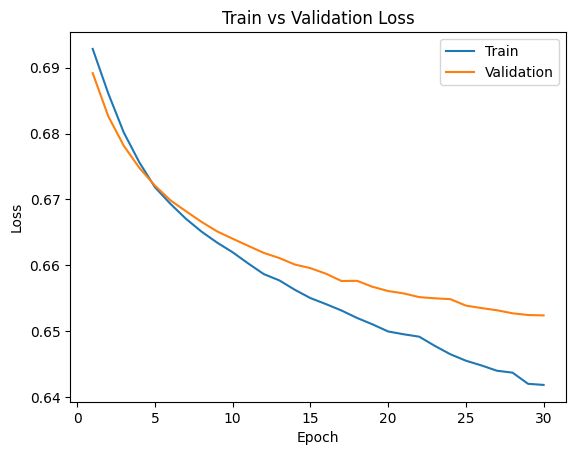

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ann"
        self.fc1 = nn.Linear(3 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

# Finding Optimal Hyperparameters

# Altering Batch Sizes

# batch = 64, lr = 0.01, epoch = 30
ann = ANN()
train_net(ann, batch_size = 64, learning_rate = 0.01, num_epochs = 30)
ann_net_path = get_model_name("ann", batch_size = 64, learning_rate = 0.01, epoch = 29)
plot_training_curve(ann_net_path)

# batch = 512, lr = 0.01, epoch = 30
ann = ANN()
train_net(ann, batch_size = 512, learning_rate = 0.01, num_epochs = 30)
ann_net_path = get_model_name("ann", batch_size = 512, learning_rate = 0.01, epoch = 29)
plot_training_curve(ann_net_path)

# batch = 16, lr = 0.01, epoch = 30
ann = ANN()
train_net(ann, batch_size = 16, learning_rate = 0.01, num_epochs = 30)
ann_net_path = get_model_name("ann", batch_size = 16, learning_rate = 0.01, epoch = 29)
plot_training_curve(ann_net_path)

# Altering Learning Rate

# batch = 64, lr = 0.001, epoch = 30
ann = ANN()
train_net(ann, batch_size = 64, learning_rate = 0.001, num_epochs = 30)
ann_net_path = get_model_name("ann", batch_size = 64, learning_rate = 0.001, epoch = 29)
plot_training_curve(ann_net_path)

# batch = 64, lr = 0.1, epoch = 30
ann = ANN()
train_net(ann, batch_size = 64, learning_rate = 0.1, num_epochs = 30)
ann_net_path = get_model_name("ann", batch_size = 64, learning_rate = 0.1, epoch = 29)
plot_training_curve(ann_net_path)

# As shown above, the best batch size is 512 while the best learning rate is 0.001

# Best ANN Model
ann = ANN()
train_net(ann, batch_size = 512, learning_rate = 0.001, num_epochs = 30)
ann_net_path = get_model_name("ann", batch_size = 512, learning_rate = 0.001, epoch = 29)
plot_training_curve(ann_net_path)

In [ ]:
# Test the best model
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(ann, test_loader, criterion)
print(f"Test error: {test_err}")
print(f"Test loss: {test_loss}")

Test error: 0.37
Test loss: 0.646045982837677


**The best ANN I trained yielded a test error of 0.37 and a test loss of 0.65, which is higher than the test error of 0.32 and the test loss of 0.59 of the best CNN model.  Therefore, the CNN model is better than the ANN model at classifying dogs and cats since ANN does not involve convolution.**